A Run avant toute chose:

1- se connecter à ton drive (pour acceder aux datas)

2- install pytorch

3- install torchtext, nltk

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/




In [0]:

# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
! pip install torchtext
import nltk
nltk.download('punkt')

    100% |████████████████████████████████| 51kB 1.9MB/s 
    100% |████████████████████████████████| 61kB 3.7MB/s 


**BIENVENUE !**

Ce notebook a pour visée de reproduire le modèle Seq2seq de la publication : avec méthode d'apprentissage type supervisé

Prérequis:
Meme voc encoder decoder

Il a pour fonctionnalités (modulables): 

1- Attention de 

2- temporal

3- decoder attention

4- Pointer generator and choice 

5- init embedding with glove and share embedding





*TODO : share embedding with projection + éviter les répétitions par NGRAM + BEP + OOV*

*BONUS : CNN en entrée + compter le nombre de poids + montrer poids décoder*

**Les imports nécessaires **

In [0]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
from nltk.tokenize import sent_tokenize, word_tokenize
from io import open
import torchtext.vocab as vocab
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [2]:
USE_CUDA =torch.cuda.is_available()
print(USE_CUDA)
MIN_LENGTH_ARTICLE=10
MIN_LENGTH_SUMMARY=5
MAX_LENGTH=50
dim=100
glove = vocab.GloVe(name='6B', dim=dim)
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

True


**Prétraitement des données**

Comme base de donnée, on a pris un échantillon de Gigawords - pour commencer

Pour faire plus jolie, on pourrait utiliser pandas -a voir-

*TODO : gérer les OOV !*

In [0]:
def get_vect_from_word(word):
    return glove.vectors[glove.stoi[word]]

def tokenize_article_in_words(text_article):
    sentences = [word_tokenize(t) for t in sent_tokenize(text_article)]
    words = []
    for sentence in sentences:
        words.extend(sentence)
    return words

def words_into_vect(words):
    vector = None
    for i, word in enumerate(words):
        if i == 0:
            try:
                vector = get_vect_from_word(word.lower())
            except Exception:
                vector = get_vect_from_word('unk')
        elif i == 1:
            try:
                vector = torch.stack((vector, get_vect_from_word(word.lower())), 1)
            except Exception:
                vector = torch.stack((vector, get_vect_from_word('unk')), 1)
        else:
            try:
                vector = torch.cat((vector, get_vect_from_word(word.lower())), 1)
            except Exception:
                vector = torch.cat((vector, get_vect_from_word('unk')), 1)
    return vector

def create_vocab_from_articles(A):
    word2index = {"PAD":0, "SOS":1,"EOS":2,"UNK": 3}
    word2count = {"UNK": 1}
    index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
    n_words = 4  # Count default tokens
    for i, article in enumerate(A):
        words=tokenize_article_in_words(article)
        for word in words:
            if word not in word2index:
                try:
                    get_vect_from_word(word.lower())
                    word2index[word] = n_words
                    word2count[word] = 1
                    index2word[n_words] = word
                    n_words += 1
                except Exception:
                    word2count["UNK"] += 1
            else:
                word2count[word] += 1
    return word2index, word2count, index2word

def create_ini_embedding(wordtoindex):
    sample=wordtoindex.keys()
    return words_into_vect(sample)

  
def pairs_and_filterpairs(articles,titles,word2index,m,n):
    pairs=[]
    pairs_test=[]
    compteur_train=0
    for k, article in enumerate(articles):
        compteur=0
        if len(article.split(' ')) >= m and len(titles[k].split(' ')) >= n:
            words=article.split(' ')
            for word in words:
                try:
                    word2index[word]
                except Exception:
                    compteur=compteur+1
            if compteur<3:
                if compteur_train % 9 != 0 or compteur_train % 8 != 0:
                  pairs.append([article,titles[k]])
                  compteur_train=compteur_train+1
                else:
                  pairs_test.append([article,titles[k]])
                  compteur_train=compteur_train+1
    return pairs,pairs_test


def indexes_from_sentence(word2index, sentence):
    ind=[]
    for word in sentence.split(' '):
        try:
            ind.append(word2index[word])
        except Exception:
            ind.append(3)
    return ind + [EOS_token]

# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

def random_batch(batch_size, pairs,word2index):
    input_seqs = []
    target_seqs = []
    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(word2index, pair[0]))
        target_seqs.append(indexes_from_sentence(word2index, pair[1]))
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]
    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()

    return input_var, input_lengths, target_var, target_lengths




In [4]:
filename_1='drive/Scrib-AI/Giga/input.txt'
filename_2='drive/Scrib-AI/Giga/task1_ref0.txt'

articles = open(filename_1, encoding='utf-8').read().strip().split('\n')
titles = open(filename_2, encoding='utf-8').read().strip().split('\n')

print("Reading lines...")
wordtoindex, wordtocount, indextoword=create_vocab_from_articles(articles)
pretrained_weight=create_ini_embedding(wordtoindex).transpose(0,1)
print('Lexique of %d words' % len(indextoword))
print("Create pairs")
pairs_train, pairs_test=pairs_and_filterpairs(articles,titles,wordtoindex, MIN_LENGTH_SUMMARY,MIN_LENGTH_ARTICLE)
print('%d pairs' % len(pairs_train))
articles_finals=[]
for i in pairs_train:
  articles_finals.append(i[0])
wti, wtc, itw=create_vocab_from_articles(articles_finals)
print('%d tokens "UNK", represent %.4f ' % (wtc["UNK"], float(wtc["UNK"])/float(len(indextoword))))

#test : random_batch(10, pairs_train, wordtoindex)

Reading lines...
Lexique of 9221 words
Create pairs
645 pairs
183 tokens "UNK", represent 0.0198 


**Utils**

In [0]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if USE_CUDA:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    if USE_CUDA:
      seq_length_expand=seq_length_expand.cuda()
    return seq_range_expand < seq_length_expand

def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))
    if USE_CUDA:
      length=length.cuda()
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss


**Modèle**

Le squelette du modèle à été pris de :
et s'est inspirés des améliorations de 

Merci à eux

In [0]:


class EncoderRNN(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, n_layers=1, dropout=0.5):
        super(EncoderRNN, self).__init__()
        
        # Define parameters
        self.input_size = input_size  # V Taille Vocabulary (can be different, here not)
        self.hidden_size = hidden_size  # H
        self.embed_size = embed_size  # E
        self.n_layers = n_layers  # L (1 per default)
        self.dropout = dropout  # 0.5 per default
        
        # Define layers
        self.embedding = nn.Embedding(input_size, embed_size)  # Init (V,E)
        self.embedding.weight = nn.Parameter(pretrained_weight) #Init with glove
        
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers, dropout=self.dropout,
                              bidirectional=True)  # Init (E,H,L, Bidirectionnel!)

    def forward(self, input_seqs, input_lengths, hidden=None):
        '''
        :param input_seqs:
            Variable of shape (T,B), T is the number of words in the longuest sentence, B is Batchsize. Contening the indexing of the words reference to the voc
        :param input_lengths:
            list of integers (len=B) which reprensents the number of words in sequence for each batch. Normally Max(input_lengths)=T
        :param hidden:
            initial state of GRU
        :returns:
            GRU outputs in shape (T,B,H)
            last hidden stat of RNN(L*bidirectionnal,B,H)
        '''
        embedded = self.embedding(input_seqs)  # (T,B,E)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded,
                                                         input_lengths)  # cf doc pytorch : take embedding and input_length. Ready to go
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)  # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]  # Sum bidirectional outputs
        return outputs, hidden  # (T,B,H),(L*bidirectionnal,B,H) | bidirectionnal=2 here



In [0]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, temporal=False):
        super(Attn, self).__init__()

        # Define parameters
        self.method = method  # 2 methods cf publi
        self.hidden_size = hidden_size  # H
        self.temporal = temporal  # Temporal attention encoder
        self.softmax = nn.Softmax()

        # Define layers
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)  # Init(2*H,H)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)


    def forward(self, hidden, encoder_outputs, E_history=None):
        '''
        :param hidden:
            (B,H)
        :param encoder_outputs:
            (T,B,H) can be also hidden decoder accumulation over time (t+1,B,H), depends on attention encoder or decoder
        :param E_history:
           Encoder history use only if intra temporal attention. Init with None, then (t,B,T)
        :returns:
            attn_energies which is alpha
        '''
        
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(H, encoder_outputs)
        
        if self.temporal:
            if E_history is None:
                E_history = attn_energies.unsqueeze(0)
            else:
                E_history = torch.cat([E_history, attn_energies.unsqueeze(0)], 0)
                hist = E_history.view(-1, this_batch_size * max_len).t()
                attn_energies = self.softmax(hist)[:, -1].contiguous().view(this_batch_size, max_len)
            return F.softmax(attn_energies).unsqueeze(1), E_history
        else:
          # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
          return F.softmax(attn_energies).unsqueeze(1)

    def score(self, hidden, encoder_output):

        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy

        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy

        elif self.method == 'concat':
            input=torch.cat([hidden, encoder_output], 2)
            energy = F.tanh(self.attn(input))  # [B*T*2H]->[B*T*H]
            energy = energy.transpose(2, 1)  # [B*H*T]
            v = self.v.repeat(encoder_output.data.shape[0], 1).unsqueeze(1)  # [B*1*H]
            energy = torch.bmm(v, energy)  # [B*1*T]
            return energy.squeeze(1)  # [B*T]

Autant le temporal ne change pas grand chose dans le deocoder.
En revanche, l'attention decoder change bcp de chose


In [0]:


class DecoderStep(nn.Module):
    """
    Class to call for each generation of word
    """
    def __init__(self, hidden_size, embed_size, output_size, n_layers, temporal=True, de_att_bol=True, point_bol=True, dropout_p=0.1):
        super(DecoderStep, self).__init__()

        # Define parameters
        self.hidden_size = hidden_size  # H
        self.output_size = output_size  # V
        self.n_layers = n_layers  # L
        self.dropout_p = dropout_p  # 0.1 per default
        self.temporal = temporal  # bolean to use intra temporal attention on input sequence cf. Temporal attention model for neural machine translation. arXiv preprint arXiv:1608.02927, 2016
        self.decoder_attention_bolean = de_att_bol  # bolean to use intra decoder attention
        self.pointer_boloan = point_bol
        
        # Define layers
        self.embedding = nn.Embedding(output_size, embed_size) # Init(V,E)
        self.dropout = nn.Dropout(dropout_p)
        self.attn_encoder = Attn('concat', hidden_size, temporal) # Init(methode score, H, bolean temporal), cf class
        if self.decoder_attention_bolean:
          self.attn_decoder = Attn('concat', hidden_size, temporal=False)
          self.gru = nn.GRU(2*hidden_size + embed_size, hidden_size, n_layers, dropout=dropout_p)# init(3*H+E,H,L) 
          self.out = nn.Linear(hidden_size * 3, output_size)  # Wout(3H,V) case [1] and [2]
          self.out_proba = nn.Linear(hidden_size * 3, 1)
        else:
          self.gru = nn.GRU(hidden_size + embed_size, hidden_size, n_layers, dropout=dropout_p)# init(2*H+E,H,L) 
          self.out = nn.Linear(hidden_size * 2, output_size)  # Wout(2H,V) case [1] and [2]
          self.out_proba = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, word_input, last_hidden, encoder_outputs,E_hist,t, hd_history, input_batches):
        '''
        :param word_input:
            tensor with SOS_Token length B
        :param last_hidden:
            Last hidden of the decoder, initialization with last hidden encoder (L,B,H)
        :param encoder_outputs:
            encoder output (T,B,H)
        :param E_hist:
            Encoder history use only if intra temporal attention. Init with None, then (1,B,T)
        :param t:
            number of time generate words [0 to max_length sequence]
        :param hd_history:
            hidden decoder accumulation over time (t+1,B,H)
        :param input_batches:
            input de l'encoder to be able to point to the entry (V,B)
        :returns:
            output decoder : max proba is the word to generate (B,V)
            hidden : will be last hidden next time
            alpha : to plot during the evaluation
            E_history : will be E_hist next time
            hd_history : will be hd_history next time
        '''
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, word_input.size(0), -1)  # (1,B,E)
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights -temporal or not- of encoder (alpha) and apply to encoder outputs (context_encoder)
        if self.temporal:
            alpha, E_history = self.attn_encoder(last_hidden[-1], encoder_outputs, E_hist)  # (B,1,T) (1,B,T)
        else:
            E_history = None  # None
            alpha = self.attn_encoder(last_hidden[-1], encoder_outputs)  # (B,1,T) alpha will be use later
        context_encoder = alpha.bmm(encoder_outputs.transpose(0, 1))  # (B,1,H)
        context_encoder = context_encoder.transpose(0, 1)  # (1,B,H) context with the encoder.
        
        # attention on decoder and RNN input
        if self.decoder_attention_bolean:
            if t:  # Recurrence
                alpha_d = self.attn_decoder(last_hidden[-1], hd_history)  # (B,1,t)
                context_decoder = alpha_d.bmm(hd_history.transpose(0, 1))  # (1,B,H)
                context_decoder = context_decoder.transpose(0, 1)  # (1,H,B)
                hd_history = torch.cat([hd_history, last_hidden[-1].unsqueeze(0)], dim=0)  # (t+1,B,H)
            else:  # Initialisation
                context_decoder = Variable(torch.zeros(1, word_embedded.size()[1], self.hidden_size))  # init to zero
                if USE_CUDA:
                  context_decoder=context_decoder.cuda()
            rnn_input_old = torch.cat((word_embedded, context_encoder), 2)
            rnn_input = torch.cat((rnn_input_old, context_decoder), 2)  # (1,B,H+E+t) idem
        else:
          # Combine embedded input word and attended context, run through RNN
          rnn_input = torch.cat((word_embedded, context_encoder), 2)
          
        #RNN
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)  # (1,B,H)->(B,H)
        context_encoder = context_encoder.squeeze(0)
        output_concat=torch.cat((output, context_encoder),1)
        
        #pointer
        if self.pointer_boloan:
          if self.decoder_attention_bolean:
              context_decoder = context_decoder.squeeze(0)
              output_concat_v2=torch.cat((output_concat, context_decoder),1)
              p_yt_sachant_paspointer=F.softmax(self.out(output_concat_v2))
              p_pointer=F.sigmoid(self.out_proba(output_concat_v2))
          else:
              p_yt_sachant_paspointer=softmax(self.out(output_concat))
              p_pointer=F.sigmoid(self.out_proba(output_concat))
          #Calcul proba finale
          alpha_interet = alpha.squeeze(1).transpose(0, 1)  # (T,B)
          batch_size = alpha_interet.size()[1]
          mask = self.alpha_to_mask(batch_size, alpha_interet, input_batches)  # (V,B), le pointeur cf equation 10
          
          proba_final = torch.mul(p_yt_sachant_paspointer, (1 - p_pointer)) + torch.mul(mask, p_pointer)  # (B,V) equation 12
          output=torch.log(proba_final)        
        else:
          if self.decoder_attention_bolean:
            context_decoder = context_decoder.squeeze(0)
            output_concat_v2=torch.cat((output_concat, context_decoder),1)
            output = F.log_softmax(self.out(output_concat_v2))
          else:
            output = F.log_softmax(self.out(output_concat))

        return output, hidden, alpha, E_history,hd_history

    def alpha_to_mask(self, batch_size, alpha_interet, input_batches):
        # Here the goal is to transform alpha_interet(T,B) into mask(V,B)
        mask = Variable(torch.zeros(batch_size, self.output_size))
        if USE_CUDA:
          mask=mask.cuda()
        for i in range(batch_size):
            for j in range(alpha_interet.size()[0]):
                mask[i, input_batches[j, i].data[0]] = alpha_interet[j, i][0]
        return mask

**TRAIN & EVALUATE**

In [0]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, E_hist=None):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Share embedding
    decoder.embedding.weight = encoder.embedding.weight
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))
    hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)
    
    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn, E_hist,hidden_history_decoder = decoder(
            decoder_input, decoder_hidden, encoder_outputs,E_hist,t, hidden_history_decoder, input_batches
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

In [0]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq.split())]
    input_seqs = [indexes_from_sentence(wordtoindex, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    hidden_history_decoder = decoder_hidden[-1].unsqueeze(0)
    E_hist = None
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention, E_hist,hidden_history_decoder = decoder(
            decoder_input, decoder_hidden, encoder_outputs,E_hist,di, hidden_history_decoder,input_batches
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(indextoword[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [0]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs_test)
    evaluate_and_show_attention(input_sentence, target_sentence)
    
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)


**Vizualisation**

In [0]:


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))



In [0]:


def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



In [0]:
def show_losses(y1,y2,y3):

  fig = plt.figure(figsize=(18, 6))
  ax1 = fig.add_subplot(1, 3, 1)
  ax2 = fig.add_subplot(1, 3, 2)
  ax3 = fig.add_subplot(1, 3, 3)
  ax1.plot(y1, label='data 1')
  ax2.plot(y2, label='data 2')
  ax3.plot(y3, label='data 3')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('encoder grad')
  ax1.set_title('GRAD ENCODER WITH EPOCH')
  ax1.legend()
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('epochs')
  ax2.set_title('GRAD DECODER WITH EPOCH')
  ax2.legend()
  ax3.set_xlabel('epochs')
  ax3.set_title('LOSS WITH EPOCH')
  ax3.legend()
  plt.show()

**MAIN**

In [0]:


# Configure models
attn_model = 'concat'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 50
embed_size=100
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 50000
epoch = 0
plot_every = 20
print_every = 100
evaluate_every = 1000
#config type model
encoder_temporal=True
decoder_attention_bol=True
pointeur_bolean=True

# Initialize models
encoder = EncoderRNN(len(indextoword),embed_size, hidden_size, n_layers, dropout=dropout)
decoder = DecoderStep(hidden_size, embed_size,len(indextoword), n_layers, dropout_p=dropout, temporal=encoder_temporal,de_att_bol=decoder_attention_bol,point_bol=pointeur_bolean )

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()



# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every



    




29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: Us

30
> the us energy department -lrb- doe -rrb- announced tuesday that an experimental project in canada to inject carbon dioxide into oil fields for its permanent storage in geologic formations proved to be successful .
= carbon dioxide permanent storage in oil field a success : us energy department
< us UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK


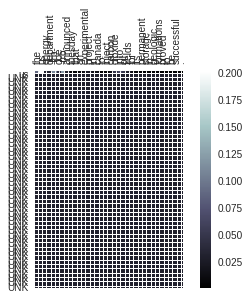

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
28m 44s (- 14342m 43s) (100 0%) 4.7028


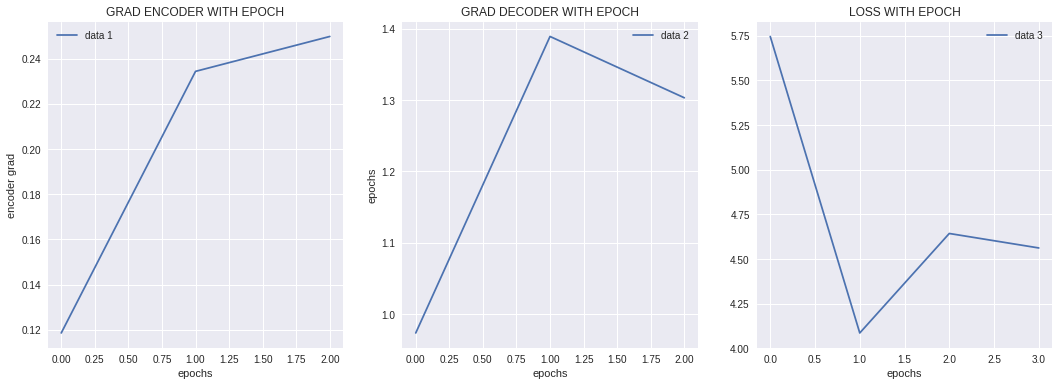

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
57m 30s (- 14320m 33s) (200 0%) 4.2222


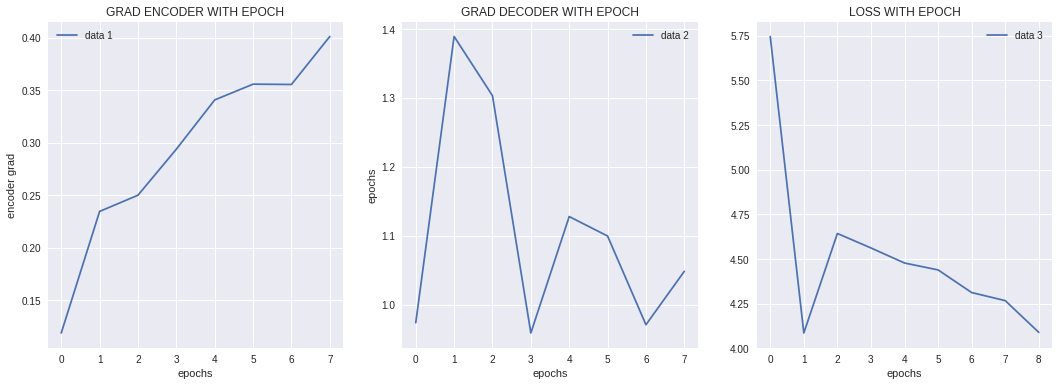

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
86m 0s (- 14247m 23s) (300 0%) 3.5941


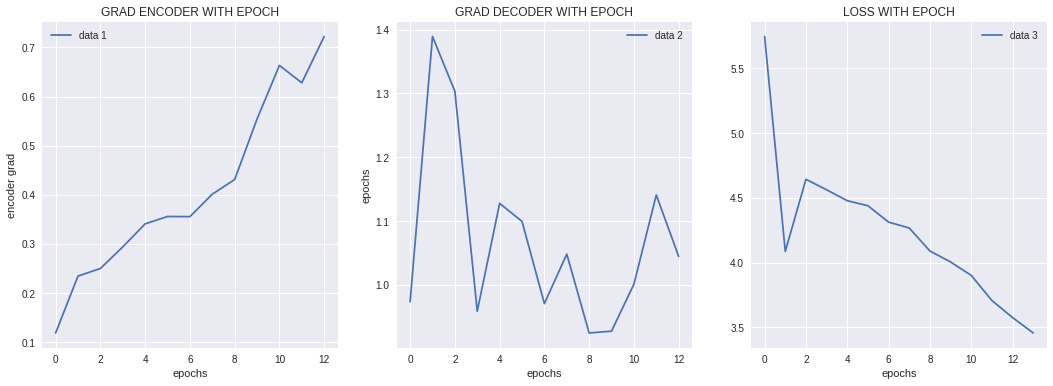

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
114m 44s (- 14228m 27s) (400 0%) 2.9420


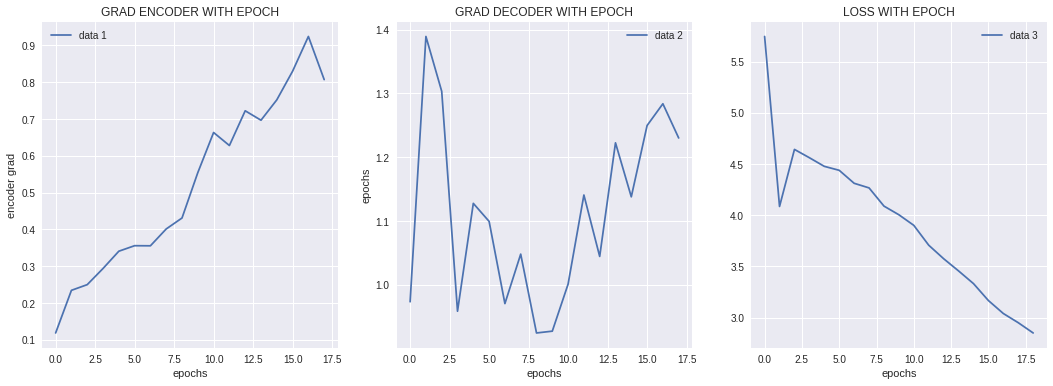

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
144m 30s (- 14305m 55s) (500 1%) 2.4564


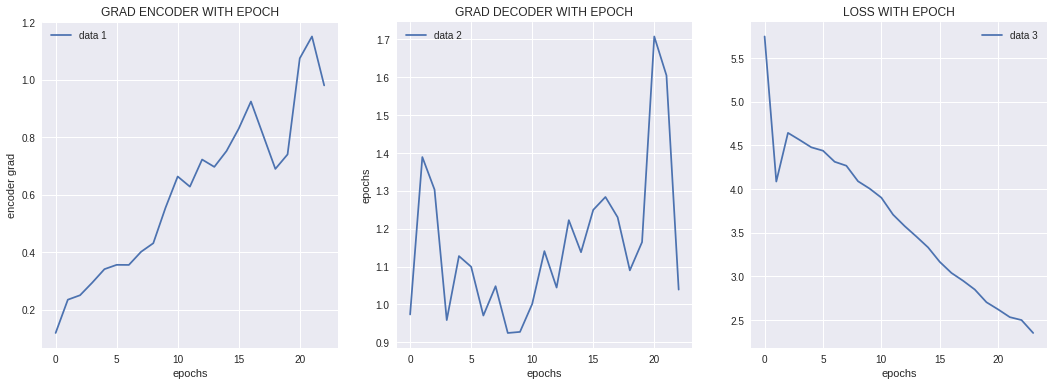

501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
172m 55s (- 14238m 8s) (600 1%) 2.0062


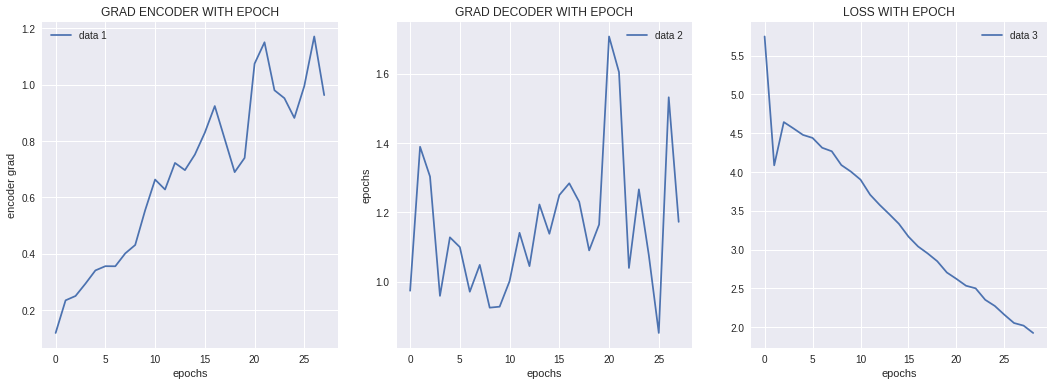

601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
203m 1s (- 14299m 2s) (700 1%) 1.6018


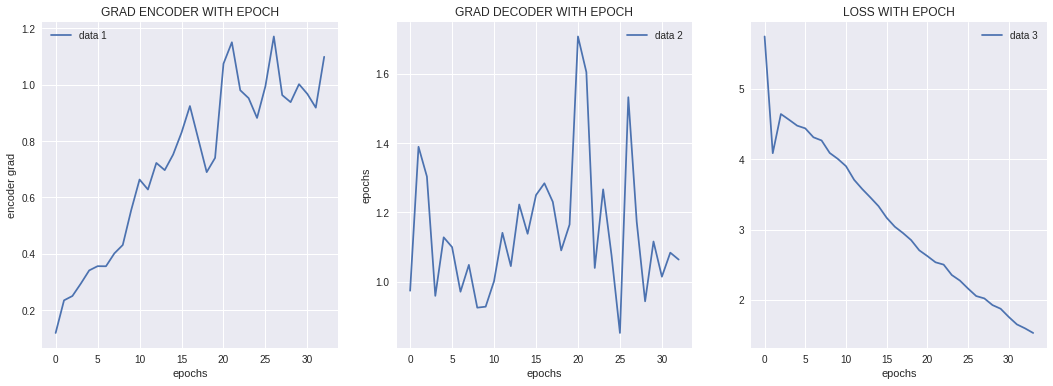

701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
231m 44s (- 14252m 27s) (800 1%) 1.2927


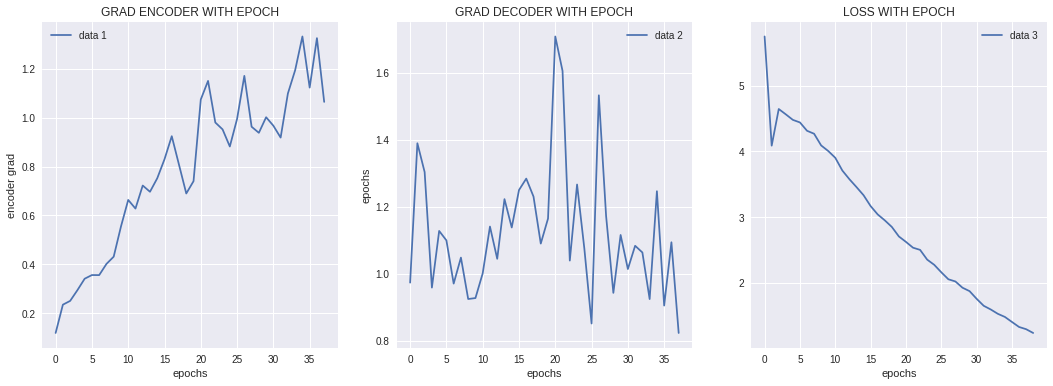

801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
261m 19s (- 14256m 53s) (900 1%) 1.0544


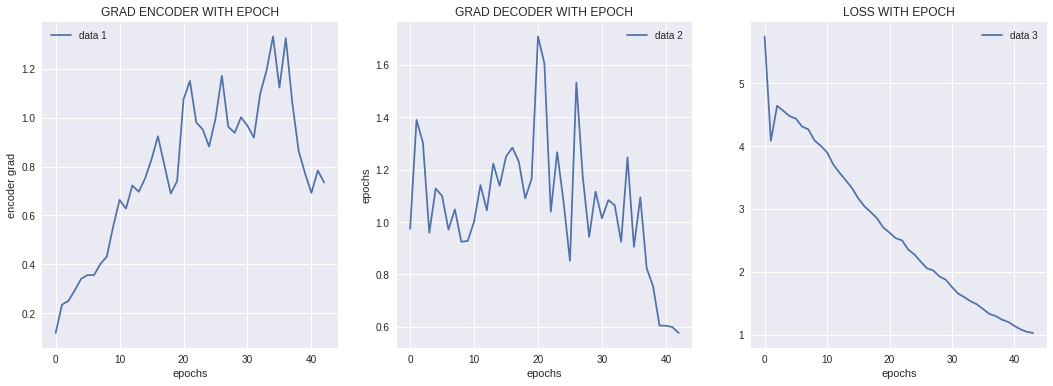

901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
290m 47s (- 14248m 53s) (1000 2%) 0.9316


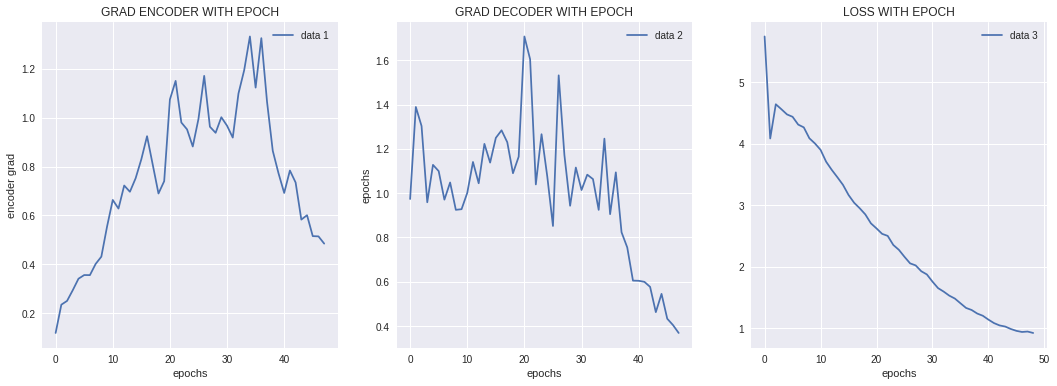

> two heads of opec arrived here tuesday for the first visit by a delegation from the oil cartel since iraq 's #### invasion of kuwait , the official news agency ina said .
= opec chiefs visit iraq for first time since #### gulf war
< UNK : UNK UNK at in UNK at in UNK chief <EOS>


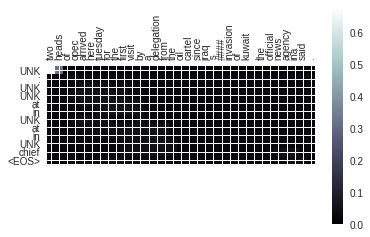

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090


In [0]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    print(epoch)
    
    #print (epoch)
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size,pairs_train, wordtoindex)
    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc

    if epoch == 30:
        evaluate_randomly()
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        show_losses(ecs,dcs,plot_losses)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)

        
        
        eca = 0
        dca = 0
        plot_loss_total = 0